(<Figure size 640x480 with 1 Axes>, <Axes: >)

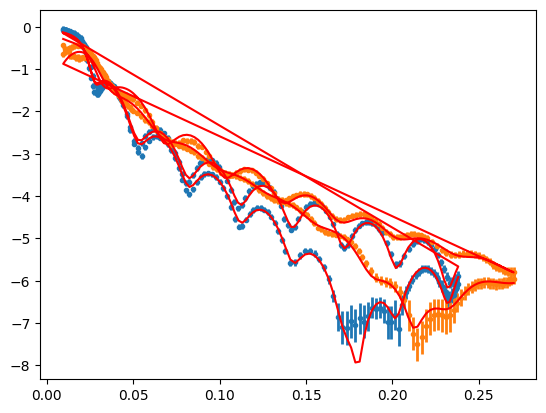

In [22]:
import pickle as pk
import polars as pl
import hvplot.polars
import matplotlib.pyplot as plt

import pyref as rf
import pyref.fitting as fit
import numpy as np

with open(f"structure.pickle", "rb") as file:
    loaded_fitter = pk.load(file)

loaded_fitter.objective.plot()

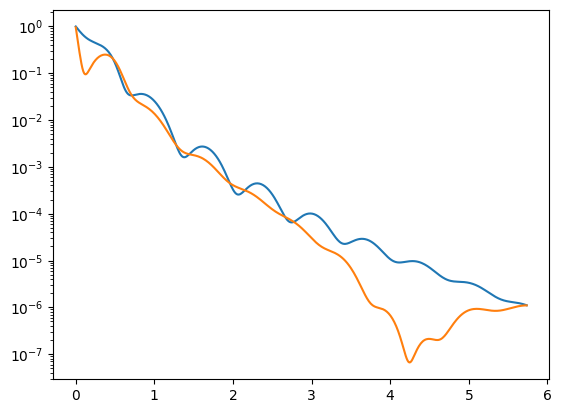

In [28]:
struct = loaded_fitter.objective.objectives[1].model.structure

model_s = fit.ReflectModel(struct, energy=283.7, pol="s")
model_p = fit.ReflectModel(struct, energy=283.7, pol="p")

energy = 283.7
lam = 1239.8 / energy

q = np.linspace(0.0001, 0.3, 500)
theta = np.arcsin(q * lam / (4 * np.pi)) * 180 / np.pi
s = model_s(q)
p = model_p(q)

# drop nans and infs
mask = np.isfinite(s) & np.isfinite(p) & np.isfinite(theta) & np.isfinite(q)
s = s[mask]
p = p[mask]
theta = theta[mask]
q = q[mask]

plt.plot(theta, s)
plt.plot(theta, p)

plt.yscale("log")

ValueError: unknown file extension: .mp4

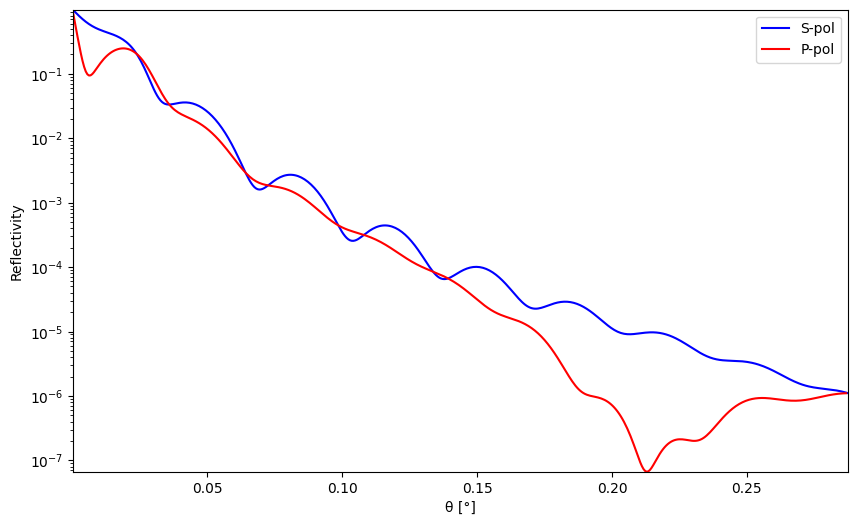

In [30]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_yscale("log")
ax.set_xlabel("θ [°]")
ax.set_ylabel("Reflectivity")

(line,) = ax.plot([], [], "b-", label="S-pol")
(line2,) = ax.plot([], [], "r-", label="P-pol")


def init():
    ax.set_xlim(q.min(), q.max())
    ax.set_ylim(min(s.min(), p.min()), max(s.max(), p.max()))
    return line, line2


def animate(frame):
    if frame < len(q):
        line.set_data(q[:frame], s[:frame])
        line2.set_data([], [])
    elif frame < len(q) + 200:  # Wait for 200 frames
        line.set_data(q, s)
        line2.set_data([], [])
    else:
        line.set_data(q, s)
        new_frame = frame - len(q) - 200
        if new_frame < len(q):
            line2.set_data(q[:new_frame], p[:new_frame])

    return line, line2


total_frames = len(q) + 200 + len(q)  # First plot + wait + second plot
anim = FuncAnimation(
    fig, animate, init_func=init, frames=total_frames, interval=1000 / 60, blit=True
)

plt.legend()

# Save as GIF with 60 fps
writer = PillowWriter(fps=60)
anim.save("reflection_animation.mp4", writer=writer)

plt.close()